# Similarity Modeling 1/2: Recognizing Kermit the Frog in Video with Feature Engineering and Machine Learning

#### Student
Matthias Hofmaier (11944050)
#### Timesheet
2022/10/10 - 2022/10/10    | Watch lecture videos and write abstracts

2022/11/23 | 16:30 - 18:00 | Setup Jupyter environment and project          

2022/11/27 | 10:00 - 11:00 | Team meeting

2022/12/04 | 19:00 - 20:00 | Team meeting

2022/12/29 | 10:00 - 18:00 | Exploration of ground truth, extraction of frames from videos, first steps in feature extraction

2022/12/30 | 10:00 - 19:00 | Research and implementation of feature extraction, implementation of model training

2022/12/31 | 15:00 - 16:00 | Team meeting

2023/01/02 | 09:00 - 15:00 | Improvement of feature extraction, implementation of hyperparameter search 

2023/01/03 | 15:00 - 19:00 | Hyperparameter search and evaluation

2023/01/04 | 12:00 - 15:00 | Documentation of notebook

2023/01/05 | 08:00 - 10:00 | Summary notebook

## Google colab integration

In [1]:
# This code block enables this notebook to run on google colab.
try:
    from google.colab import drive

    print("Running in colab...\n===================")
    COLAB = True
    drive.mount("/content/gdrive")
    root_path = "gdrive/MyDrive/similarity-modeling"

except:
    print("=======================\nNOT running in colab...\n=======================")
    COLAB = False

NOT running in colab...


## Required libraries and installs
**We use Python 3.9**

In [2]:
if COLAB:
    !cat $root_path/notebooks/requirements-fe-video.txt
    !pip install -r $root_path/notebooks/requirements-fe-video.txt
else:
    !cat requirements-fe-video.txt
    !pip install -r requirements-fe-video.txt

pandas
numpy
opencv-python
scikit-learn
#librosa==0.9.2
tqdm
#tensorflow==2.9.2
matplotlib==3.1.3
scipy
optuna
plotly
seaborn


**NOTE:** ffmpeg has to be installed on your device!
This can be done with one of the following commands:

In [3]:
#!brew install ffmpeg # MacOS (tested)
#!sudo apt install ffmpeg # Ubuntu (not tested)

For windows check: https://phoenixnap.com/kb/ffmpeg-windows

## Imports

In [4]:
import os

import cv2
import joblib
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

/Users/mhf/opt/anaconda3/envs/sm-fe-ml-video/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

In [5]:
if COLAB:
    DATA_PATH = os.path.join(root_path, "data")
else:
    DATA_PATH = "../data/"

GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")  # CSV DATA
VIDEO_PATH = os.path.join(DATA_PATH, "video")  # VIDEO FILES
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, "processed")

RANDOM_STATE = 42

# 1. Data Preparation

## 1.1 Load ground truth data
The columns in the CSV files indicate at which frames Kermit, Waldorf & Statler, Pigs and/or the Danish chef are visually present (no prefix) or can be heared ("Audio_*").

In [6]:
gts = []
for fname in os.listdir(GROUND_TRUTH_PATH):
    if fname.startswith("GroundTruth"):
        df = pd.read_csv(os.path.join(GROUND_TRUTH_PATH, fname), sep=";")
        gts.append(df)
gts[0].head()

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
0,343,0,0,0,0,0,0,0,0,0
1,343,1,0,0,0,0,0,0,0,0
2,343,2,0,0,0,0,0,0,0,0
3,343,3,0,0,0,0,0,0,0,0
4,343,4,0,0,0,0,0,0,0,0


The column that is of our interest is 'Kermit'.

## 1.2 Load video data

In [7]:
# def load_video(path):
videos = []
for fname in os.listdir(VIDEO_PATH):
    if fname.startswith("Muppets"):
        vidcap = cv2.VideoCapture(os.path.join(VIDEO_PATH, fname))
        fps = vidcap.get(cv2.CAP_PROP_FPS)
        videos.append(vidcap)
        print(f"Loaded video {fname} with {fps} frames per second")

Loaded video Muppets-02-01-01.avi with 25.0 frames per second
Loaded video Muppets-03-04-03.avi with 25.0 frames per second
Loaded video Muppets-02-04-04.avi with 25.0 frames per second


All of the videos have 25 frames per second. This comes in handy for the exploration of csv data.

In [8]:
FPS = 25

## 1.3 Show some descriptions of the data

Video: 343
Number of frames: 38498
Number of frames with Kermit: 15508
Length: 1539.92 seconds


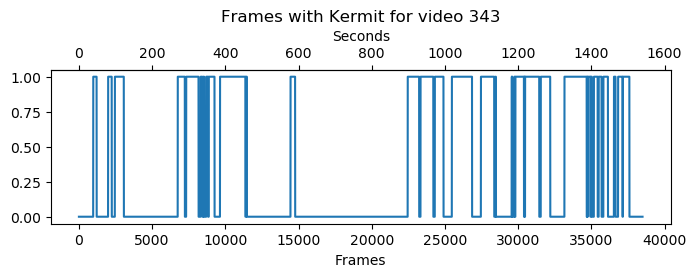

Video: 244
Number of frames: 38706
Number of frames with Kermit: 12252
Length: 1548.24 seconds


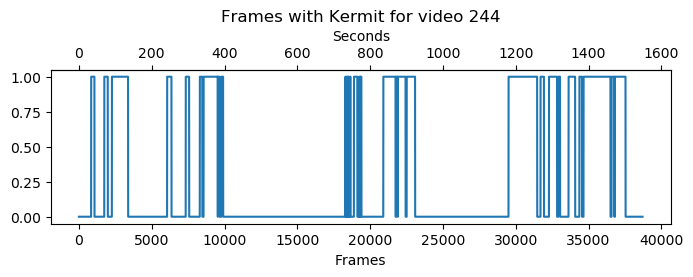

Video: 211
Number of frames: 38681
Number of frames with Kermit: 5449
Length: 1547.24 seconds


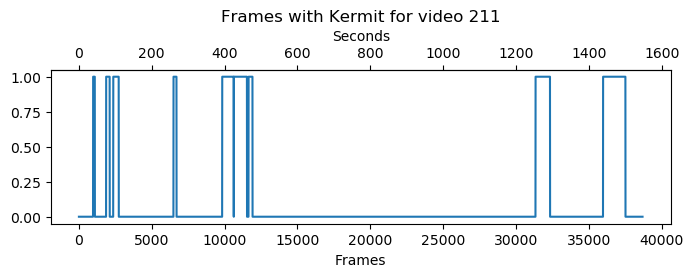

In [9]:
def show_gt_description(df, column="Kermit", fps=25):
    print(f"Video: {df.loc[0, 'Video']}")
    print(f"Number of frames: {df['Frame_number'].count()}")
    print(
        f"Number of frames with {column}: {df.loc[df[column] == 1, 'Frame_number'].count()}"
    )
    print(f"Length: {len(df['Frame_number']) / fps} seconds")

    # plotting with frames and seconds as x-axis
    fig = plt.figure(figsize=(8, 2))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f"Frames with {column} for video {df.loc[0, 'Video']}")
    ax1.set_xlabel("Frames")
    frame_indicator = np.zeros(len(df["Frame_number"]))
    frame_indicator[df[df[column] == 1].index] = 1
    ax1.plot(df[column].index, frame_indicator)

    def frames_to_sec(x):
        return x / fps

    def sec_to_frames(x):
        return x * fps

    ax2 = ax1.secondary_xaxis("top", functions=(frames_to_sec, sec_to_frames))
    ax2.set_xlabel("Seconds")
    plt.show()


show_gt_description(gts[0])
show_gt_description(gts[1])
show_gt_description(gts[2])

We can see that Kermit occurs in all of the videos. In the next step, we will combine our ground truth dataframes into one, filter for the Kermit column and add a column seconds to the data frame. 

## 1.4 Combine data frames, filter for Kermit and add seconds

In [10]:
df_gt = pd.concat(gts)
df_gt["Seconds"] = df_gt["Frame_number"] / FPS
df_gt = df_gt[["Video", "Frame_number", "Seconds", "Kermit"]]
df_gt.head()

,Video,Frame_number,Seconds,Kermit
0,343,0,0.00,0
1,343,1,0.04,0
2,343,2,0.08,0
3,343,3,0.12,0
4,343,4,0.16,0


In the next step, we will convert the video files to frames

## 1.5 Convert videos to frames

In [11]:
KERMIT_FRAME_PATH = os.path.join(PROCESSED_DATA_PATH, "kermit-frames")

if not os.path.exists(KERMIT_FRAME_PATH):

    map_code_to_file = {211: "02-01-01", 244: "02-04-04", 343: "03-04-03"}

    os.makedirs(KERMIT_FRAME_PATH, exist_ok=True)

    for code in df_gt["Video"].unique():
        fname_in = f"Muppets-{map_code_to_file[code]}.avi"

        # open a videoCap for this video
        video_cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, fname_in))

        i = 0
        while video_cap.isOpened():
            ret, frame = video_cap.read()
            if ret == False:
                break
            fname_out = f"kermit_{code}_f{i}.jpg"
            cv2.imwrite(os.path.join(KERMIT_FRAME_PATH, fname_out), frame)
            i += 1

            if i % 5000 == 0:
                print(f"Converted {i} frames")

        video_cap.release()
        cv2.destroyAllWindows()

        print(
            f"Converted {fname_in} to {i} frames under {os.path.join(KERMIT_FRAME_PATH, fname_out)}"
        )

## 1.6 Create train, validation, test split
We will use 70% of the frames for training, 15% for validation and 15% for testing. We split in a stratified manner, to retain an equal distribution of the label across all data splits. 

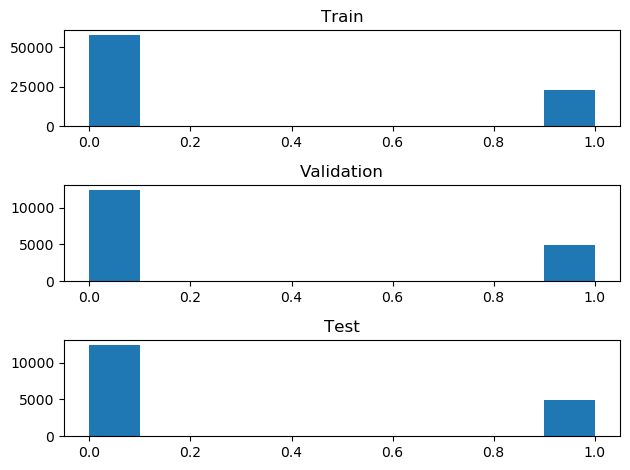

In [12]:
train, _val_test = train_test_split(
    df_gt, test_size=0.3, stratify=df_gt["Kermit"], random_state=RANDOM_STATE
)

val, test = train_test_split(
    _val_test, test_size=0.5, stratify=_val_test["Kermit"], random_state=RANDOM_STATE
)

fig, axs = plt.subplots(3)
rects_train = axs[0].hist(train["Kermit"])
axs[0].set_title("Train")

rects_val = axs[1].hist(val["Kermit"])
axs[1].set_title("Validation")

rects_test = axs[2].hist(test["Kermit"])
axs[2].set_title("Test")

plt.tight_layout()
plt.show()

## 1.7 Create class weights
As our task boils down to an imbalanced classification problem, we will employ class weights. The class weights are calculated as the inverse class proportions in the training set.

In [13]:
cw_negative = len(train) / len(train[train["Kermit"] == 0])
cw_positive = len(train) / len(train[train["Kermit"] == 1])

print(f"Class weight Kermit not present: {cw_negative}")
print(f"Class weight Kermit present: {cw_positive}")

class_weights = {0: cw_negative, 1: cw_positive}

Class weight Kermit not present: 1.4016726279957838
Class weight Kermit present: 3.4895896068140755


## 1.8 Extract features from frames
Now the interesting part of this notebook starts, the extraction of features from the video frames. Our first take included the following steps:

1. Conversion of the video frame to HSV color space.
2. Thresholding the frame based on a range of greens, corresponding to the color of Kermit.  
3. Detect contours (shapes) in the green thresholded frame.
4. Calculation of areas of the detected contours. Our hypothesis is that we will find larger contours for frames where Kermit is present than for frames where he is not.
5. Calculation of statistics of the contour areas. If no contours were found, we will create an array of zeros.
6. Calculation of Hu Moments of the thresholded image. Hu Moments are 7 numbers calculated using central moments (weighted averages of pixel intensities) that are invariant to image translations and describe the shape present in an image.    

These steps did result in a very simple 15-dimensional feature vector on which we trained a SVM and a RandomForest. Here, we obtained average precision (AP) values of ~70% on the validation set. For the RandomForest, we observed an AP value close to 100% for the training set, which was a clear indicator for overfitting. As these results were not satisfactory for us, we continued to add more complex features:

7. Extraction of bounding boxes from the 3 largest contours found in the image. 
8. Merging of the bounding boxes into 1 large bounding box. 
9. Using found bounding box to crop region of interest from the original frame.
10. Conversion of cropped image to HSV color space.
11. Calculation of histogram for each color channel separately. Concatenation of color channel histograms.

Our assumption is that if Kermit is present in the image, the color histograms of the cropped image show a very similar distribution, with greens for the body, whites for the eyes and reds for the mouth present. If Kermit is not present, the color histograms should show random distributions of colors between the frames. 

Helpful sources we employed for the feature extraction:
- https://pyimagesearch.com/2014/10/27/opencv-shape-descriptor-hu-moments-example/
- https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv
- https://stackoverflow.com/questions/28759253/how-to-crop-the-internal-area-of-a-contour
- https://learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/
- https://learnopencv.com/shape-matching-using-hu-moments-c-python/

In [14]:
def extract_frame_features(fpath, plot=False):

    # read image
    image = cv2.imread(fpath)

    # threshold image based on green range in HSV model
    GREEN_MIN = np.array([30, 60, 70], np.uint8)
    GREEN_MAX = np.array([45, 255, 255], np.uint8)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    img_threshed = cv2.inRange(hsv_img, GREEN_MIN, GREEN_MAX)

    # detect contours (shapes) in thresholded frame
    contours, hierarchy = cv2.findContours(
        image=img_threshed, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE
    )

    # calculate areas of found countours
    areas = [cv2.contourArea(cont) for cont in contours]

    # calculate statistics of contour areas
    if len(areas) > 0:
        area_stats = [
            np.min(areas),
            np.max(areas),
            np.mean(areas),
            np.std(areas),
            np.sum(areas),
            kurtosis(areas),
            skew(areas),
            len(areas),
        ]
    else:
        area_stats = np.zeros(8)

    # calculate HuMoments of thresholded frame
    hu_moments_thres = cv2.HuMoments(cv2.moments(img_threshed)).flatten()

    # extract bounding boxes from contours of thresholded frame
    def merge_boxes(bboxes):
        # IN: array of bboxes with shape (n, [x_min, y_min, x_max, y_max])
        merged = (
            np.min(bboxes[:, 0]),  # take minimum x coord
            np.min(bboxes[:, 1]),  # take minimum y coord
            np.max(bboxes[:, 2]),  # take maximum x coord
            np.max(bboxes[:, 3]),  # take maximum y coord
        )
        # OUT: single merged bounding box
        return np.array(merged)

    def extract_bounding_box(contours, number_of_boxes=3):
        # get list of contour areas
        cnt_area = [cv2.contourArea(cont) for cont in contours]
        cnt_area = sorted(cnt_area, reverse=True)
        bboxes = []
        # Loop through each contour of our image
        for i in range(0, len(contours), 1):
            cnt = contours[i]

            # Only extract the the largest number of boxes
            if cv2.contourArea(cnt) > cnt_area[min(len(cnt_area) - 1, number_of_boxes)]:

                # Use OpenCV boundingRect function to get bbox of the contour
                x_min, y_min, w, h = cv2.boundingRect(cnt)
                x_max = x_min + w
                y_max = y_min + h

                bbox = (x_min, y_min, x_max, y_max)
                bboxes.append(bbox)

        bboxes = np.array(bboxes)
        if len(bboxes) > 0:  # if bboxes were found, merge them
            bbox_merged = merge_boxes(bboxes)
        else:
            bbox_merged = None
        return bbox_merged

    bbox = extract_bounding_box(contours)

    # crop image with help of bounding box
    if bbox is not None:  # if box was found
        img_bbox_crop = image[bbox[1] : bbox[3], bbox[0] : bbox[2]]

        # convert image to hsv and create color histogram
        img_bbox_crop_hsv = cv2.cvtColor(img_bbox_crop, cv2.COLOR_BGR2HSV)
        channels = ["h", "s", "v"]
        histograms = {}
        for i, channel in enumerate(channels):
            histograms[channel] = cv2.calcHist(
                [img_bbox_crop_hsv], [i], None, [256], [0, 256]
            )
        histograms_arr = np.concatenate(
            list(histograms.values())
        ).flatten()  # concat histograms to single vector

    else:  # if not
        histograms_arr = np.zeros((256 * 3))  # use empty histograms

    if plot:
        fig, axs = plt.subplots(1, 3)
        axs[0].imshow(image)
        axs[0].set_title("Original")
        axs[1].imshow(img_threshed)
        axs[1].set_title("Thresholded")

        # draw contours on the original image
        image_cont = image.copy()
        cv2.drawContours(
            image=image_cont,
            contours=contours,
            contourIdx=-1,
            color=(0, 255, 0),
            thickness=2,
            lineType=cv2.LINE_AA,
        )
        axs[2].imshow(image_cont)
        axs[2].set_title("With contours")

        if bbox is not None:
            fig2, axs2 = plt.subplots(1, 2, figsize=(5, 2))
            axs2[0].imshow(img_bbox_crop)
            axs2[0].set_title("Cropped image")

            for channel in histograms:
                axs2[1].plot(histograms[channel], label=channel)
            axs2[1].set_title("Color histogram of cropped image")
            axs2[1].legend()

        plt.tight_layout()
        plt.show()

    return np.concatenate([area_stats, hu_moments_thres, histograms_arr])

### 1.7.1 Test feature extraction for random positive and negative examples
We will now randomly sample frames with Kermit present and not present to test the proposed feature extraction techniques.


Example files with Kermit present


,Video,Frame_number,Seconds,Kermit
35335,343,35335,1413.40,1
37190,211,37190,1487.60,1
2436,211,2436,97.44,1


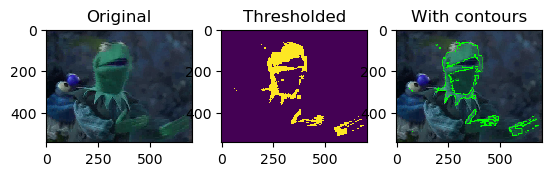

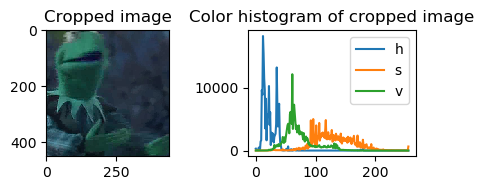

--------------------------------------------------------------------------------


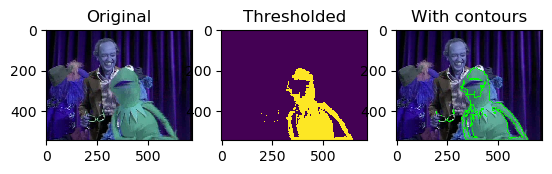

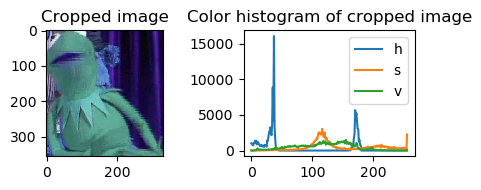

--------------------------------------------------------------------------------


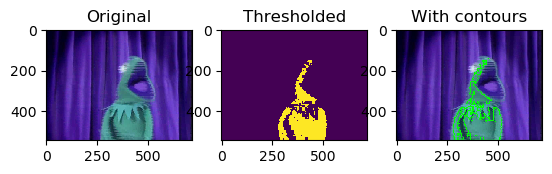

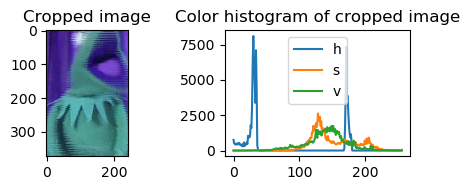

--------------------------------------------------------------------------------
Example files with Kermit NOT present


,Video,Frame_number,Seconds,Kermit
17178,211,17178,687.12,0
26700,244,26700,1068.00,0
19536,343,19536,781.44,0


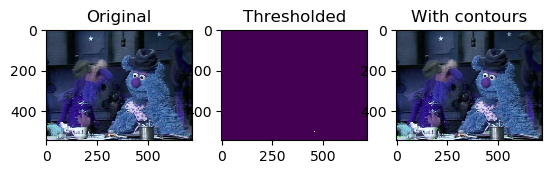

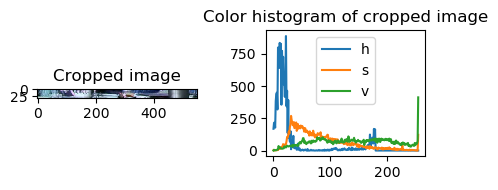

--------------------------------------------------------------------------------


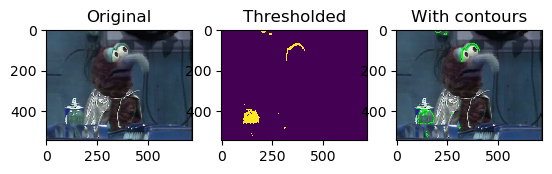

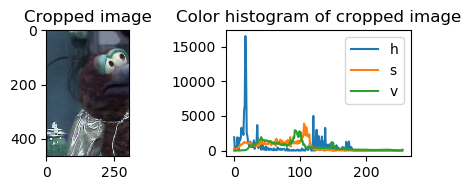

--------------------------------------------------------------------------------


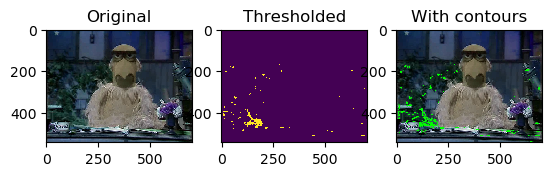

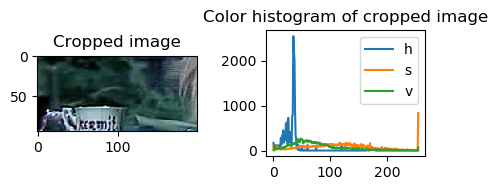

--------------------------------------------------------------------------------


In [15]:
# sample examples
n_examples = 3
positive_examples = df_gt[df_gt["Kermit"] == 1].sample(
    n_examples, random_state=RANDOM_STATE
)
negative_examples = df_gt[df_gt["Kermit"] == 0].sample(
    n_examples, random_state=RANDOM_STATE
)

# Kermit present
print("=" * 80)
print("Example files with Kermit present")
print("=" * 80)
display(positive_examples)
for idx, row in positive_examples.iterrows():
    video = int(row["Video"])
    frame_number = int(row["Frame_number"])
    fname = f"kermit_{video}_f{frame_number}.jpg"
    _ = extract_frame_features(os.path.join(KERMIT_FRAME_PATH, fname), plot=True)
    print("-" * 80)


# Kermit not present
print("=" * 80)
print("Example files with Kermit NOT present")
print("=" * 80)
display(negative_examples)
for idx, row in negative_examples.iterrows():
    video = int(row["Video"])
    frame_number = int(row["Frame_number"])
    fname = f"kermit_{video}_f{frame_number}.jpg"
    _ = extract_frame_features(os.path.join(KERMIT_FRAME_PATH, fname), plot=True)
    print("-" * 80)

For the frames where Kermit is present, we can see that the thresholding based on color works well and Kermit is clearly recognizable in the thresholded image. Also, the found contours show a reasonable size, which supports our approach of using statistics of the contour areas as features. 
For frames without Kermit present, the thresholded image only contains small spots. These are parts of the image which also contain green color, but are not Kermit. The same can be observed for the contours, which are very small for images where Kermit is not present. 
The cropped images, that were created by merging the bounding boxes of the 3 largest contours, also look very promising. For frames in which Kermit is present, the cropped image clearly contains Kermit and only a small part of the background. For frames without Kermit, the cropped images are random parts of the frame that contain green color. Detecting a difference between present and not present frames from the color histograms alone is difficult, but should be easy for a machine learning model.

### 1.7.2 Extract features for all frames

In [ ]:
def create_Xy(df):
    X = []
    y = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        video = int(row["Video"])
        frame_number = int(row["Frame_number"])
        label = row["Kermit"]
        fname = f"kermit_{video}_f{frame_number}.jpg"
        feats = extract_frame_features(os.path.join(KERMIT_FRAME_PATH, fname))
        X.append(feats)
        y.append(label)

    X = np.stack(X)
    y = np.array(y)
    return X, y


X_train, y_train = create_Xy(train)
X_val, y_val = create_Xy(val)
X_test, y_test = create_Xy(test)

# save features + labels to file
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
with open(os.path.join(PROCESSED_DATA_PATH, "X_train_kermit.npy"), "wb") as f:
    np.save(f, X_train, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_train_kermit.npy"), "wb") as f:
    np.save(f, y_train, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_val_kermit.npy"), "wb") as f:
    np.save(f, X_val, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_val_kermit.npy"), "wb") as f:
    np.save(f, y_val, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_test_kermit.npy"), "wb") as f:
    np.save(f, X_test, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_test_kermit.npy"), "wb") as f:
    np.save(f, y_test, allow_pickle=False)

### 1.7.3 Load extracted features

In [16]:
if os.path.exists(PROCESSED_DATA_PATH):
    with open(os.path.join(PROCESSED_DATA_PATH, "X_train_kermit.npy"), "rb") as f:
        X_train = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_train_kermit.npy"), "rb") as f:
        y_train = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_val_kermit.npy"), "rb") as f:
        X_val = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_val_kermit.npy"), "rb") as f:
        y_val = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_test_kermit.npy"), "rb") as f:
        X_test = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_test_kermit.npy"), "rb") as f:
        y_test = np.load(f)
    print("Loaded frame features from disk!")

Loaded frame features from disk!


# 2. Modeling
Now we will train some machine learning models to recognize which feature vectors correspond to frames where Kermit is present or not. We will use a Support Vector Machine and a Random Forest. Both models will first of all be trained with a fixed setting of hyperparameters on a subsample of the data. In the second step, we will employ a hyperparameter search to find good model configurations. Both models will be trained on the train split of the dataset and evaluated on the validation split. The test split will only be used later for final validation of the models. Because scikit-learn does not provide an PRAUC metric, we decided to use the average precision (AP) as metric to summarize the success of our models with a single number.

## 2.1 Support Vector Machine

In [38]:
def fit_evaluate_SVC(
    X_train,
    y_train,
    X_val,
    y_val,
    params=None,
    class_weights=class_weights,
    smoke_test=False,
    random_state=42,
):
    if smoke_test:
        X_train = X_train[:1000]
        y_train = y_train[:1000]

    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)

    # fit classifier
    if params is None:
        clf = make_pipeline(
            StandardScaler(),
            SVC(
                gamma="auto",
                class_weight=class_weights,
                random_state=random_state,
                verbose=True,
            ),
        )
    else:
        clf = make_pipeline(
            StandardScaler(),
            SVC(
                C=params["C"],
                gamma=params["gamma"],
                kernel=params["kernel"],
                shrinking=params["shrinking"],
                class_weight=class_weights,
                random_state=random_state,
            ),
        )
    clf.fit(X_train, y_train)

    # prediction
    y_hat_train = clf.predict(X_train)
    y_hat_val = clf.predict(X_val)

    # evaluation
    ap_train = average_precision_score(y_train, y_hat_train)
    ap_val = average_precision_score(y_val, y_hat_val)

    return ap_train, ap_val


fit_evaluate_SVC(X_train, y_train, X_val, y_val, smoke_test=True)

[LibSVM]*
optimization finished, #iter = 830
obj = -418.734707, rho = -0.401633
nSV = 453, nBSV = 213
Total nSV = 453


(0.8391027154663518, 0.746096219889588)

Trained on a subsample of 1000 observations, the Support Vector Machine already shows promising results. On the training set, we reach an AP of 83.91%, on the validation set we reach an AP of 74.6%.

## 2.2 Random Forest

In [39]:
def fit_evaluate_RF(
    X_train,
    y_train,
    X_val,
    y_val,
    params=None,
    class_weights=class_weights,
    smoke_test=False,
    random_state=42,
):
    if smoke_test:
        X_train = X_train[:1000]
        y_train = y_train[:1000]

    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)

    # fit classifier
    if params is None:
        clf = RandomForestClassifier(
            min_samples_split=10,
            min_samples_leaf=10,
            max_depth=50,
            n_jobs=-1,
            class_weight=class_weights,
            random_state=random_state,
            verbose=True,
        )
    else:
        clf = RandomForestClassifier(
            n_estimators=params["n_estimators"],
            max_features=params["max_features"],
            max_depth=params["max_depth"],
            min_samples_split=params["min_samples_split"],
            min_samples_leaf=params["min_samples_leaf"],
            bootstrap=params["bootstrap"],
            class_weight=class_weights,
            random_state=random_state,
        )
    clf.fit(X_train, y_train)

    # prediction
    y_hat_train = clf.predict(X_train)
    y_hat_val = clf.predict(X_val)

    # evaluation
    ap_train = average_precision_score(y_train, y_hat_train)
    ap_val = average_precision_score(y_val, y_hat_val)

    return ap_train, ap_val


fit_evaluate_RF(X_train, y_train, X_val, y_val, smoke_test=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


(0.8640589844937671, 0.7727803539458886)

The results of the Random Forest model look even more promising. Here we obtain an AP of 86.4% on the training set and 77.27% on the validation set.

## 2.3 Perform hyperparameter search
Now we will perform a hyperparameter search with the library Optuna. Optuna will use an informed search algorithm to find the optimal hyperparameters in the search space. We will threat the type of the classifier also a hyperparameter, that we will included in the search.

As the search of the hyperparameters takes a long time to execute, we included the results as pickle file.

In [ ]:
# 1. Define an objective function to be maximized.
def objective(trial, X_train, y_train, X_val, y_val):

    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        C = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        gamma = trial.suggest_float("svc_gamma", 1e-10, 1e10, log=True)
        kernel = trial.suggest_categorical("svc_kernel", ["rbf", "sigmoid", "linear"])
        shrinking = trial.suggest_categorical("svc_shrinking", [True, False])

        params = {"C": C, "gamma": gamma, "kernel": kernel, "shrinking": shrinking}

        ap_train, ap_val = fit_evaluate_SVC(
            X_train, y_train, X_val, y_val, params=params
        )

    else:
        n_estimators = trial.suggest_int(
            "rf_n_estimators", 50, 250, log=True
        )  # number of trees in the random forest
        max_features = trial.suggest_categorical(
            "rf_max_features", ["auto", "sqrt", "log2"]
        )  # number of features in consideration at every split
        max_depth = trial.suggest_int(
            "rf_max_depth", 30, 100, log=True
        )  # maximum number of levels allowed in each decision tree
        min_samples_split = trial.suggest_int(
            "rf_min_samples_split", 10, 1000, log=True
        )  # minimum sample number to split a node
        min_samples_leaf = trial.suggest_int(
            "rf_min_samples_leaf", 10, 1000, log=True
        )  # minimum sample number that can be stored in a leaf node
        bootstrap = trial.suggest_categorical(
            "rf_bootstrap", [True, False]
        )  # method used to sample data points

        params = {
            "n_estimators": n_estimators,
            "max_features": max_features,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
            "bootstrap": bootstrap,
        }

        ap_train, ap_val = fit_evaluate_RF(
            X_train, y_train, X_val, y_val, params=params
        )

    return ap_val


STUDY_PATH = "video_fe_hyperparam_optimization.pkl"

if not os.path.exists(STUDY_PATH):
    # 3. Create a study object and optimize the objective function.
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, X_val, y_val),
        n_trials=200,
        n_jobs=6,
    )
    study = optuna.create_study()

### 2.3.1 Show best trial and save study to file

In [ ]:
print(study.best_trial)
joblib.dump(study, "video_fe_hyperparam_optimization.pkl")

### 2.3.2 Load study from disk and create data frame

In [40]:
study = joblib.load("video_fe_hyperparam_optimization.pkl")
df_study = study.trials_dataframe()
df_study = df_study[df_study["state"] == "COMPLETE"]

### 2.3.4 Visualize results

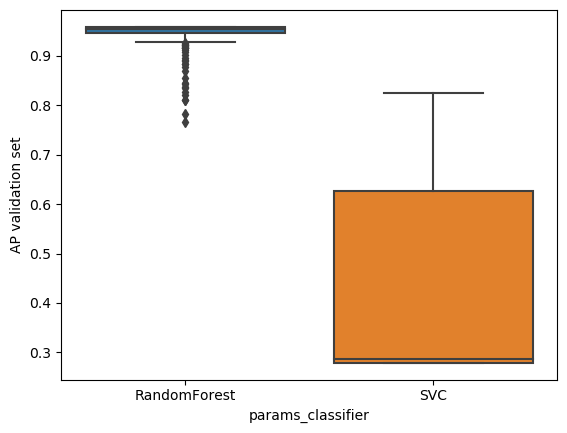

In [41]:
fig, ax = plt.subplots()
sns.boxplot(x="params_classifier", y="value", data=df_study, ax=ax)
ax.set_ylabel("AP validation set")
plt.show()

In the boxplot above, we can clearly see that the Random Forest models outperform the Support Vector Machines in terms of AP on the validation set. Therefore, we decide to use the Random Forest as our final model, an will only perform further analysis for Random Forest trials.

params_rf_bootstrap False
params_rf_max_depth 96.0
params_rf_max_features auto
params_rf_min_samples_leaf 10.0
params_rf_min_samples_split 13.0
params_rf_n_estimators 220.0
ap_val 0.9587890650111551


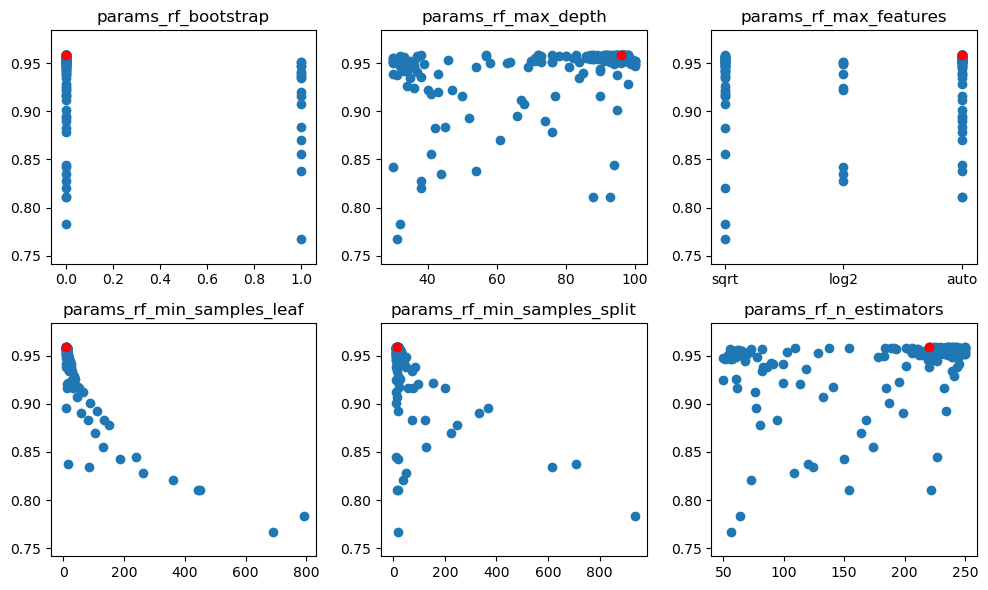

In [42]:
df_study_rf = df_study[df_study["params_classifier"] == "RandomForest"]

best_run = df_study_rf.sort_values(by="value", ascending=False).head(1)

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.flatten()
i = 0
for col in df_study_rf.columns.values:
    if col.startswith("params_rf"):
        axs[i].scatter(df_study_rf[col], df_study_rf["value"])
        axs[i].scatter(best_run[col], best_run["value"], color="red")
        axs[i].set_title(col)
        print(col, best_run[col].item())
        i += 1
print("ap_val", best_run["value"].item())
plt.tight_layout()
plt.show()

The best hyperparameters that were found for the Random Forest model are shown above. In the plots, we can see the AP on the validation set, plotted against the values of the hyperparameters. The red dots are the values that were optimal. In the next step we will fit a Random Forest with those parameters.

## 2.4 Fit model with suggested hyperparameters

In [43]:
clf = RandomForestClassifier(
    n_estimators=220,
    max_features="sqrt",  # sqrt equals auto, but auto is deprecated
    max_depth=96,
    min_samples_split=13,
    min_samples_leaf=10,
    bootstrap=False,
    class_weight=class_weights,
    random_state=RANDOM_STATE,
    n_jobs=6,
    verbose=True,
)

clf.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   13.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   59.5s
[Parallel(n_jobs=6)]: Done 220 out of 220 | elapsed:  1.2min finished


RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1.4016726279957838,
                                     1: 3.4895896068140755},
                       max_depth=96, min_samples_leaf=10, min_samples_split=13,
                       n_estimators=220, n_jobs=6, random_state=42,
                       verbose=True)

# 3. Evaluation

## 3.1 Predict

In [45]:
# prediction
print("Predicting train data...")
y_hat_train = clf.predict_proba(X_train)[
    :, 1
]  # use probabilities of positive class only
print("Predicting val data...")
y_hat_val = clf.predict_proba(X_val)[:, 1]
print("Predicting test data...")
y_hat_test = clf.predict_proba(X_test)[:, 1]

Predicting train data...


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 220 out of 220 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s


Predicting val data...
Predicting test data...


[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 220 out of 220 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 220 out of 220 | elapsed:    0.1s finished


## 3.2 Calculate PR curve for validation set and find optimal cutoff value
The ROC curve could also be used to find the optimal cutoff value, but as this lead to very unstable results, when using a different dataset split, we will stick to the PR curve for threshold estimation.

In [46]:
precision, recall, thresholds = precision_recall_curve(y_val, y_hat_val)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
optimal_idx = np.argmax(fscore)
optimal_cutoff = thresholds[optimal_idx]
print(f"Found optimal cutoff threshold at {optimal_cutoff}")

Found optimal cutoff threshold at 0.5339552123390309


## 3.3 Show ROC curves

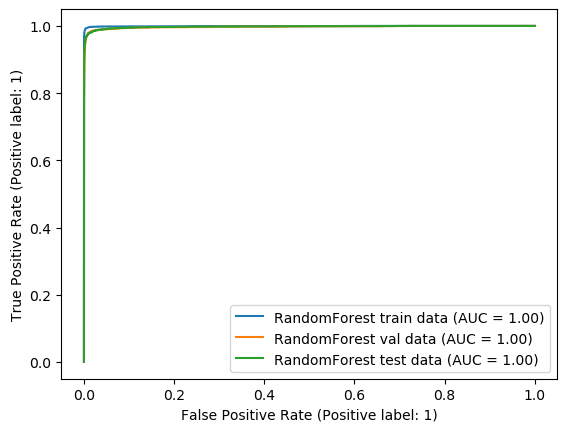

In [47]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    y_train, y_hat_train, name="RandomForest train data", ax=ax
)

RocCurveDisplay.from_predictions(y_val, y_hat_val, name="RandomForest val data", ax=ax)

RocCurveDisplay.from_predictions(
    y_test, y_hat_test, name="RandomForest test data", ax=ax
)
plt.show()

The ROC curve looks perfect for all dataset splits.

## 3.4 Discretize predictions to calculate further metrics

In [48]:
# discretize predictions
cutoff = optimal_cutoff

y_hat_train_discrete = y_hat_train.copy()
y_hat_train_discrete[y_hat_train_discrete < cutoff] = 0
y_hat_train_discrete[y_hat_train_discrete >= cutoff] = 1

y_hat_val_discrete = y_hat_val.copy()
y_hat_val_discrete[y_hat_val_discrete < cutoff] = 0
y_hat_val_discrete[y_hat_val_discrete >= cutoff] = 1

y_hat_test_discrete = y_hat_test.copy()
y_hat_test_discrete[y_hat_test_discrete < cutoff] = 0
y_hat_test_discrete[y_hat_test_discrete >= cutoff] = 1

## 3.5 Calculate metrics
We will calculate the Precision, Recall, Fscore and the AP over the train, validation, and test set.

In [49]:
# precision, recall, fscore
prf = {}
prf["train"] = precision_recall_fscore_support(
    y_train, y_hat_train_discrete, average="binary"
)
prf["val"] = precision_recall_fscore_support(
    y_val, y_hat_val_discrete, average="binary"
)
prf["test"] = precision_recall_fscore_support(
    y_test, y_hat_test_discrete, average="binary"
)

# average precision
ap = {}
ap["train"] = average_precision_score(y_train, y_hat_train_discrete)
ap["val"] = average_precision_score(y_val, y_hat_val_discrete)
ap["test"] = average_precision_score(y_test, y_hat_test_discrete)

## 3.6 Visualize Results

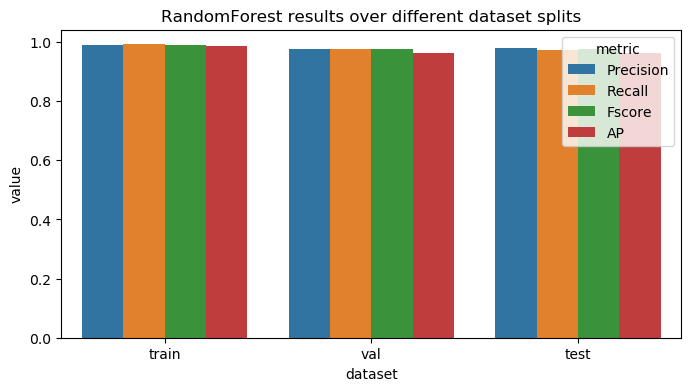

In [50]:
# make dataframe
res_holder = []
for ds in ["train", "val", "test"]:
    precision = {"dataset": ds, "metric": "Precision", "value": prf[ds][0]}
    recall = {"dataset": ds, "metric": "Recall", "value": prf[ds][1]}
    fscore = {"dataset": ds, "metric": "Fscore", "value": prf[ds][2]}
    avg_precision = {"dataset": ds, "metric": "AP", "value": ap[ds]}
    res_holder.append(precision)
    res_holder.append(recall)
    res_holder.append(fscore)
    res_holder.append(avg_precision)

res_df = pd.DataFrame(res_holder)

# plot
fig, ax = plt.subplots(figsize=(8, 4))
g = sns.barplot(data=res_df, x="dataset", y="value", hue="metric", ax=ax).set(
    title="RandomForest results over different dataset splits"
)
plt.show()

In plot above, we can see that the model performs almost perfectly across all metrics and dataset splits. From the plot, there is no overfitting observable, although Random Forest models are very prone to that. One thing we have to note is that due to the way we split our dataset into train, validation and test, there is the possibility that frames that are directly following each other (i.e., are only very slightly different) can be in all of the dataset splits. To test how robust the classifiers perform in the wild, it would be better to use a video aware split, i.e., use one of the videos for training, one of the videos for validation and one of the videos for testing, or to use a completely new video for final evaluation and keep the current split. 